# Tackling the Credit Card Fraud dataset with Random Forest

In this kernel, I investigate the credit card fraud dataset and ultimately opt for working with a random forest model.

This dataset provides us with data in the form of PCA components, the amounts associated with each transaction, the time at which they occurred (in this kernel, we have not explored this variable, but based on other kernels, it does not seem to play a key role), and whether a given transaction is fraudulent or not.

In the first part of this kernel, we do a uni/bi-variate analysis to determine what PCA components might be more relevant in drawing a line between fraudulent and non-fraudulent transactions. This is used to reduce the dimensionality of this problem.

In the second part, we look at the variable amount in more detail. We find that quite a few transactions, fraudulent or not, correspond to an amount of 0. We eliminated these transactions on the basis that they do not aggregate any immediate financial value. Perhaps given more context for the problem, it would make sense to retain these transactions.

Our investigation also reveals that the only a small subset of the fraudulent transactions (about 150 of the total 492 fraudulent transactions) account for about 95% of the total amount loss due to frauds. We felt like it would be better to create a separate model to account for the small-amount transactions. This seemly led to small improvements in the recall metric for fraudulent transactions without affecting the precision much.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import neighbors
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import decomposition
import scipy

In [2]:
rawdf = pd.read_csv("creditcard.csv", delimiter = ",")

In [3]:
rawdf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
rawdf.shape

(284807, 31)

Time seems to represent the time at which the transaction happened...?

V1, V2, ..., V28 represent PCA components associated with the true data, which cannot be disclosured.

Amount represents the amount involved in a given transaction.

Class = 0 is the label for non-fraudulent transactions.
Class = 1 is the label for fraudulent transactions.

Let's check how many of each we have.



In [5]:
n_fraud = rawdf.Class[rawdf.Class==1].count()
n_legit = rawdf.Class[rawdf.Class==0].count()

print(n_fraud, n_legit)

492 284315


# First Step: Univariate and Bivariate analysis

Let's prepare some variables to make the data exploration easier

In [6]:
#Looking at the dataset overall statistics

#We will get into more detail about some of the statistics later. In particular, we care about the variable amount.
rawdf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
PCA_list = rawdf.columns[1:29] #contains the labels V1, V2, ..., V28
PCA_index = np.arange(1,29) #vector with numbers 1, 2, 3, ..., 28

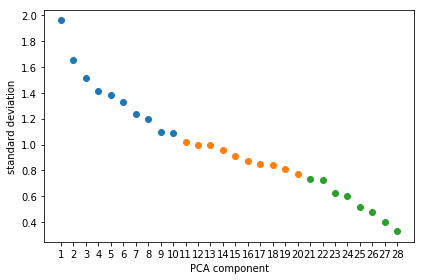

In [8]:
plt.plot(PCA_index[0:10], rawdf[PCA_list[0:10]].std(), 'o')
plt.plot(PCA_index[10:20], rawdf[PCA_list[10:20]].std(), 'o')
plt.plot(PCA_index[20:29], rawdf[PCA_list[20:29]].std(), 'o')
plt.ylabel("standard deviation")
plt.xlabel("PCA component")
plt.xticks(PCA_index)
plt.tight_layout()

#This plot just confirms our expectation that the standard deviation is decreasing for higher PCA components.

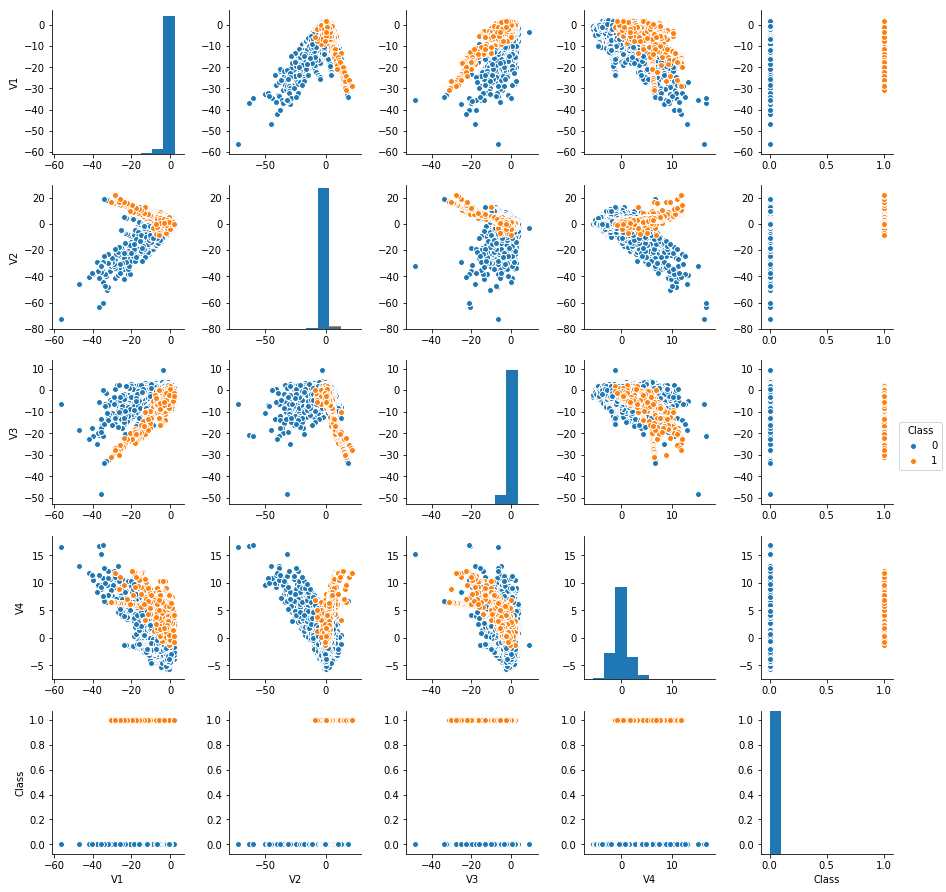

In [9]:
#Let's take a look at the first few components to have a feeling for bivariate distributions

PCA_shortlist = list(PCA_list[0:4])
PCA_shortlist.append('Class')
sns.pairplot(rawdf[PCA_shortlist], hue='Class')
plt.show()

We do see a tendency for fraudulent transactions to form their own cluster, though it certainly overlaps with the clusters of non-fraudulent transactions. The hope is that we might be able to draw a line between the different labels in the multi-dimensional space.

Let us now look at the histograms for various PCA components.

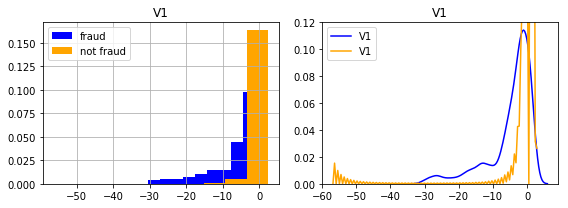

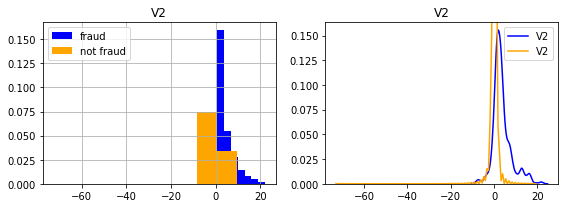

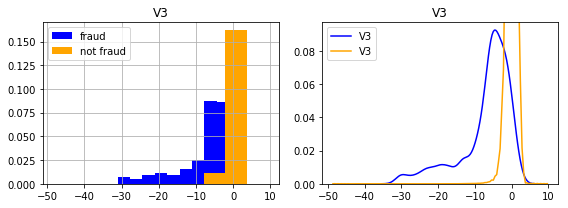

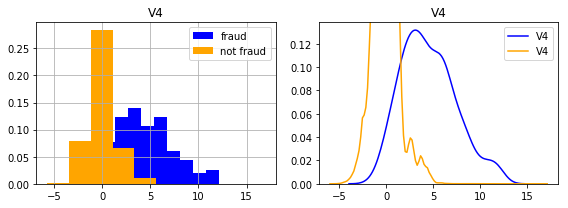

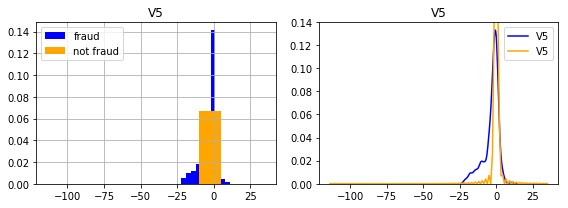

In [10]:
#histograms for various PCA components

components = ["V1", "V2", "V3", "V4", "V5"]

for PCA_comp in components:
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    rawdf[rawdf.Class == 1][PCA_comp].hist(label="fraud", color="blue", density='True')
    rawdf[rawdf.Class == 0][PCA_comp].hist(label="not fraud", color="orange", density='True')
    plt.title(PCA_comp)
   # sns.kdeplot(rawdf[rawdf.Class == 1][PCA_comp], color="blue")
   # sns.kdeplot(rawdf[rawdf.Class == 0][PCA_comp], color='orange')
    plt.legend()
    
    plt.subplot(1,2,2)
    sns.kdeplot(rawdf[rawdf.Class == 1][PCA_comp], color='blue')
    sns.kdeplot(rawdf[rawdf.Class == 0][PCA_comp], color='orange')
    plt.tight_layout()
    plt.title(PCA_comp)

From the plots above we can see that there are noticeable deviations for the PCA components for various fraudulent transactions.

For the sake of dimensionality reduction, let's take a look at higher PCA components to see if the effect is diminished.

In what follows below, we have added components that we think will be ultimately irrelevant, but it is easy to adjust the code to show the remaining components.

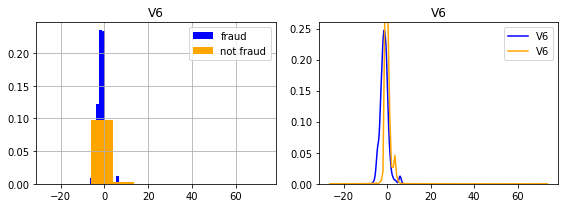

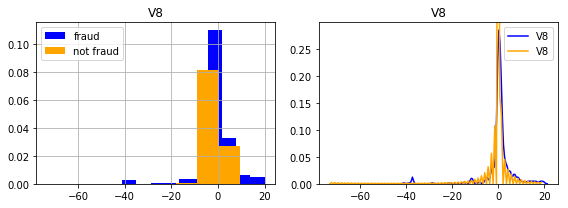

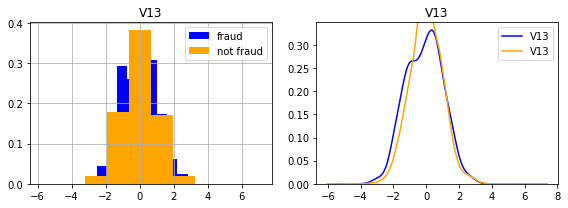

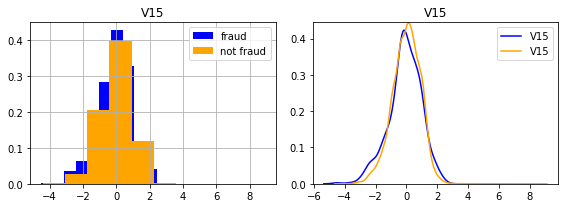

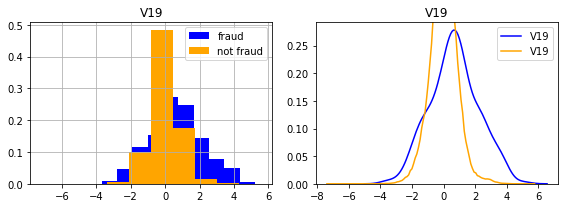

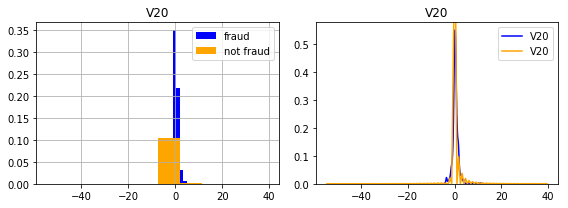

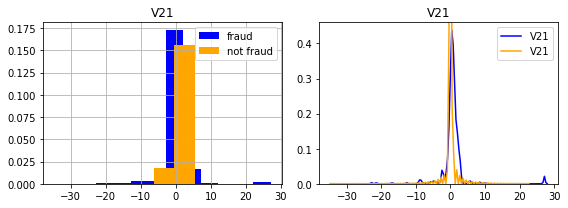

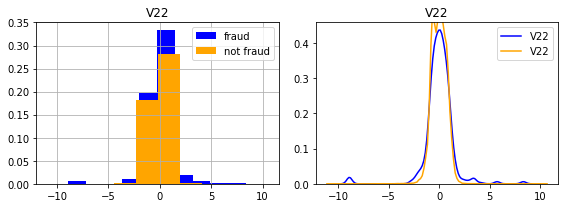

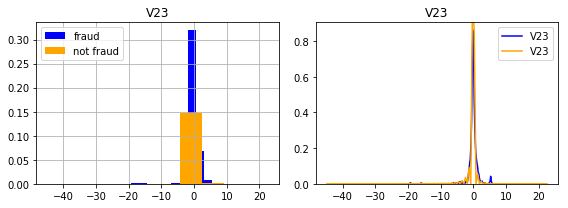

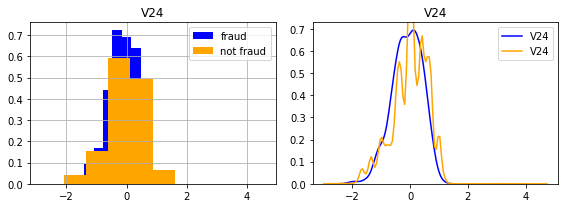

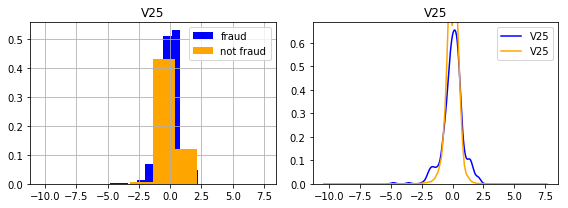

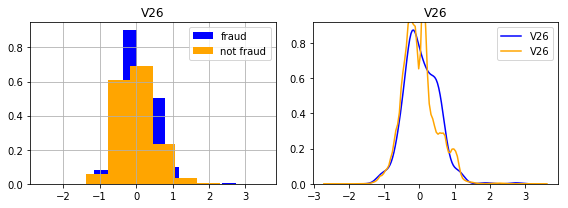

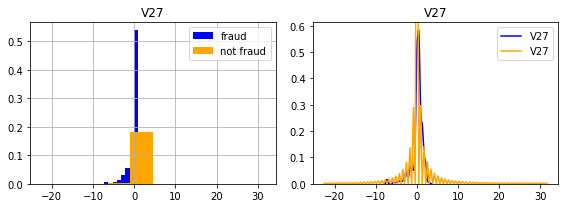

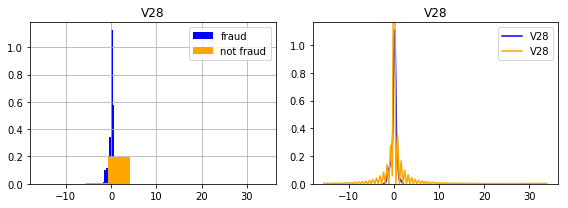

In [11]:
components = ["V6", "V8", "V13", "V15", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28"]

for PCA_comp in components:
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    rawdf[rawdf.Class == 1][PCA_comp].hist(label="fraud", color="blue", density='True')
    rawdf[rawdf.Class == 0][PCA_comp].hist(label="not fraud", color="orange", density='True')
    plt.title(PCA_comp)
   # sns.kdeplot(rawdf[rawdf.Class == 1][PCA_comp], color="blue")
   # sns.kdeplot(rawdf[rawdf.Class == 0][PCA_comp], color='orange')
    plt.legend()
    
    plt.subplot(1,2,2)
    sns.kdeplot(rawdf[rawdf.Class == 1][PCA_comp], color='blue')
    sns.kdeplot(rawdf[rawdf.Class == 0][PCA_comp], color='orange')
    plt.tight_layout()
    plt.title(PCA_comp)



The plots above suggest cutting out components starting from V19 and above. We can later readjust to verify improvements.
There are also some random components that do not seem to contribute much. V13 and V15 do not seem very useful. Neither do V6 and V8.

I looked at correlations between PCA components and the class labels with the loop below.
It was fruitless: the imbalance makes every correlation be simply too small. There might be some workaround, but I decide not to pursue this any further, leaving the results here for the sake of clarity and completeness.

In [12]:
from scipy.stats import spearmanr
for component in PCA_list[:3]:
    print("The current component is "+component)
    print(spearmanr(rawdf[component], rawdf["Class"]))

The current component is V1
SpearmanrResult(correlation=-0.042423503910599056, pvalue=1.3831008872943118e-113)
The current component is V2
SpearmanrResult(correlation=0.05106178228574506, pvalue=1.0176224173864534e-163)
The current component is V3
SpearmanrResult(correlation=-0.05927837684982331, pvalue=5.025821522544823e-220)


The problem with the above is that, since the dataset is vastly dominated by class 0, the correlation is very weak. 
What we will do instead is to quantify the difference between the distributions for every PCA component when class = 0 and when class = 1.

I decided next to compute KS statistic. In practice, that turned out not to be so useful either, but let's see what we get.

In [13]:
from scipy.stats import ks_2samp

In [14]:
#Null hypothesis: two samples are drawn from the same distribution.
for component in PCA_list[:3]:
        print("The current component is "+component)
        print(ks_2samp(rawdf[rawdf.Class==1][component], rawdf[rawdf.Class==0][component]))

The current component is V1
Ks_2sampResult(statistic=0.4753308729911244, pvalue=6.66047999095129e-98)
The current component is V2
Ks_2sampResult(statistic=0.6332012800985509, pvalue=2.0940243533799856e-173)
The current component is V3
Ks_2sampResult(statistic=0.7036817131004787, pvalue=4.673955990176099e-214)


The KS metric was also not that helpful. It is simply stating that, given the two samples (class 0 and 1), we know that they are coming from different distributions, and every single PCA component is capable of confirming that (you can easily adapt the loop above to look at all components).

That said, in a real situation, what matters is not a sample, but a single point. Thus, the KS metric ends up not being so helpful in practice. 

Though I have not quantified this on here, what matters is that a point will be difficult to classify when it resides in an area where two distributions associated with labels 0 and 1, respectively, overlap too much. Thus, I eliminate components for which that happens. For now, this procedure will have to be based on visual inspection. It is worth considering whether this could be made more rigorous at some point.

Before we proceed, let us look at the variable 'Amount'.

We realized after some attempts that it is better to limit ourselves to amounts smaller than 1000 at first because most transactions are concentrated in this region.

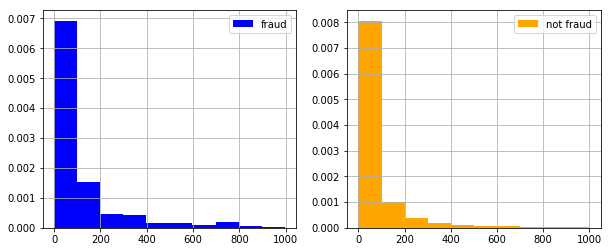

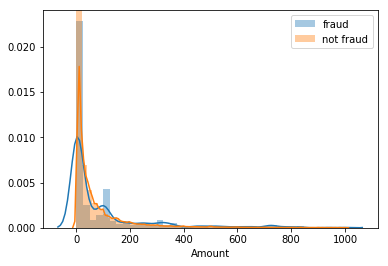

In [15]:
#Before we proceed to the next step, lets look at the variable amount.

crit_amount = 1000

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
rawdf[rawdf.Class==1]['Amount'][rawdf.Amount < crit_amount].hist(label="fraud", color="blue", density='True')
plt.legend()
plt.subplot(1,2,2)
rawdf[rawdf.Class==0]['Amount'][rawdf.Amount < crit_amount].hist(label="not fraud", color="orange", density='True')
plt.legend()

plt.figure()
sns.distplot(rawdf[rawdf.Class==1].Amount[rawdf.Amount < crit_amount], label='fraud')
sns.distplot(rawdf[rawdf.Class==0].Amount[rawdf.Amount < crit_amount], label='not fraud')
plt.legend()


A very tiny portion of the dataset (about 1%) corresponds to transactions about the critical value of 1000

Strangely enough, quite a few transactions correspond to the amount 0. We will drop those transactions from the dataset at this point.

In [16]:
rawdf = rawdf[rawdf.Amount>0]
print(rawdf.Amount[rawdf.Class==1].count())
#this is the updated number of fraudulent transactions

465


In [17]:
print("Non-fraudulent transactions, amount above 1000: "+
      str(rawdf[rawdf.Class==0].Amount[rawdf.Amount > crit_amount].count()))
print("Fraudulent transactions, amount above 1000: "+
       str(rawdf[rawdf.Class==1].Amount[rawdf.Amount > crit_amount].count()))

Non-fraudulent transactions, amount above 1000: 2931
Fraudulent transactions, amount above 1000: 9


We would like to know what transaction range is responsible for most of the losses.

In [18]:
print(rawdf.Amount.groupby(rawdf.Class).describe())

print(rawdf.Amount.groupby(rawdf.Class).sum())

          count        mean         std   min   25%    50%    75%       max
Class                                                                      
0      282517.0   88.852926  250.800179  0.01  5.99  22.49   78.0  25691.16
1         465.0  129.307462  262.298781  0.01  1.00  17.06  111.7   2125.87
Class
0    2.510246e+07
1    6.012797e+04
Name: Amount, dtype: float64


From the above, we can see the total amount associated with class 0 and with class 1.
We can also see that the vast majority of transactions is below about the value of 100 (about 75%).
However, we do not care so much about the number of transactions, but the amount lost from such transactions combined. We will see next, for example, that even though the low-amount transactions outnumber the high-amount ones, the 150 transactions with the highest amounts are responsible for 95% of all losses. Hence, it is much more important to focus on those.

Let's see how losses stack up next to confirm what we just said.

Text(0.5,0,'Number of transactions (starting from the lowest)')

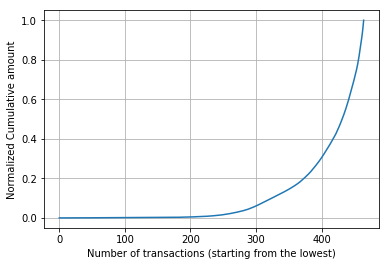

In [19]:
amounts_fraud = np.asarray(rawdf.Amount[rawdf.Class==1]) #array with the amounts of fraudulent transactions
amounts_fraud.sort() #amount sorted in ascending order
cum_amounts_fraud = np.cumsum(amounts_fraud) #array with the cumulative sum 
#plt.style.use('ggplot')

total = cum_amounts_fraud[-1] #total amount, used to normalize the cumulative sum

plt.figure()
plt.grid()
plt.plot(cum_amounts_fraud/total)
plt.ylabel("Normalized Cumulative amount")
plt.xlabel("Number of transactions (starting from the lowest)")

In [20]:
#A few more useful numbers to have in mind (we did not pick these numbers randomly; they are based on the plot above)

print("Fraction associated with the lowest 300 transactions: "+ 
      str(amounts_fraud[0:300].sum()/total)) 

print("Fraction associated with the highest 100 transactions: "+
      str(amounts_fraud[365:].sum()/total)) 

print("Amount at which the 300th transaction starts: "+
      str(amounts_fraud[300]))

print("Amount lost associated with the 10 highest transactions: "+
      str(amounts_fraud[455:].sum()/total))

print("Amount associated with the 10 most expensive transactions:" )
print(str(amounts_fraud[455:]))


Fraction associated with the lowest 300 transactions: 0.059099783345421444
Fraction associated with the highest 100 transactions: 0.8250704289534471
Amount at which the 300th transaction starts: 88.23
Amount lost associated with the 10 highest transactions: 0.23672177856661378
Amount associated with the 10 most expensive transactions:
[ 996.27 1096.99 1218.89 1335.   1354.25 1389.56 1402.16 1504.93 1809.68
 2125.87]


From the above, we conclude that the 300 transactions with the lowest amounts account for less than 10% of the losses. It might be worth eliminating them at some point and treating the remaining transactions separately. 

About 100 transactions account for 80% of the losses (the ones between 365 and 465)

The 300th transaction starts at about an amount of 88. It provides with a number to further reduce the dataset if we decide to cut transactions below that.

Finally, the 10 most expensive transactions are responsible for almost 25% of the losses. This is a very large number, and given that we have only 10 points in this region, it might be difficult to develop an algorithm that would work well in this sector. It might be worth looking at those points alone to see if they would stand out somehow as an expansion on this kernel. In the last line, we see that those more expensive transactions begin at amount > 996, approximately.

In [21]:
#Let's check if the dataset balance improves in the region starting from amount = 88 and above. 
rawdf.Amount[rawdf.Amount > 88][rawdf.Class==1].count()/rawdf.Amount[rawdf.Amount > 88].count()

0.002573803026544282

The imbalance has improved slightly (the original ratio was something like 0.0017).

In what follows, we will concentrate ourselves on this sector with amounts above 88. 

# Trying some models

To have a feel for how good the models can do, we will summon quite a few for a preliminary analysis.

# Data Transformation step

We start by dropping some components that seemed somewhat unimportant according to the histograms we had at the beginning.

In [22]:
df = rawdf[(rawdf.Amount > 88)].copy()
cols_to_drop = ["V6", "V8", "V13", "V15", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", 
                "V27", "V28", "Time", "Amount"]
df.drop(cols_to_drop, inplace=True, axis=1)
df.head()

,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,0.370145,-0.392048,-0.410430,-0.705117,-0.110452,0.074355,-0.210077,-0.499768,0.118765,0
12,1.249999,-1.221637,0.383930,-1.234899,-1.485419,-0.689405,-2.094011,1.323729,0.227666,-0.242682,-0.317631,-0.815612,0.873936,-0.847789,0


In [23]:
Y = df.Class 
X = df.drop("Class", axis=1)

# Calling various models

In [24]:
#Calling a few models

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

MLA = [
    ensemble.RandomForestClassifier(),
    linear_model.LogisticRegression(),
    naive_bayes.GaussianNB() ]

len(MLA)

#We originally tried more models, but some of them took very long times to train.
#We ultimately reduced the list to a few just for the purposes of illustration
#In the end we will pick the random forest model. It has a decent performance and takes a reasonable time to train.

3

In [25]:
#create table to compare different model metrics
MLA_columns = ['Name', 'Parameters','Train Score Mean', 'Test Score Mean', 'Test STD']
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [26]:
from sklearn import model_selection
from sklearn.model_selection import  StratifiedKFold, cross_val_score
row_index = 0

cv_method = StratifiedKFold(n_splits=5, shuffle=True)

for model in MLA:
    model_name = model.__class__.__name__
    print(model_name)
    cv_results = model_selection.cross_validate(model, X, Y, 
                                                cv  = cv_method, 
                                                return_train_score=True,
                                                scoring="f1")
    
    
    MLA_compare.loc[row_index, 'Name'] = model_name
    MLA_compare.loc[row_index, 'Parameters'] = str(model.get_params())
    
    MLA_compare.loc[row_index, 'Train Score Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'Test Score Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'Test STD'] = cv_results['test_score'].std() 
    
    row_index+=1

RandomForestClassifier
LogisticRegression
GaussianNB


In [27]:
MLA_compare.sort_values(by = ['Test Score Mean'], ascending = False, inplace = True)
MLA_compare

,Name,Parameters,Train Score Mean,Test Score Mean,Test STD
0,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.973653,0.841071,0.0599989
1,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.62851,0.629245,0.0598171
2,GaussianNB,{'priors': None},0.22774,0.228479,0.0184861


Since random forest seems to do do better for F1, let's develop this model further.

In what follows next, we will try four different strategies:
-Random forest, assigning class weights to labels 0 and 1
-Oversampling (SMOTE)
-Undersampling (random)
-Combined oversampling and undersampling

We start by splitting the dataset into training and test set. 30% will be left for test.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                stratify=Y, 
                                                test_size=0.3)

Next we do oversampling and undersampling. This must be done on the training set; not on the test set. 
In the case of oversampling, it is important for the test set not to be used to generate extra samples, otherwise it will make the model biased towards the test set.

In the case of undersampling, the idea is that we still would like to see how the model can perform on an imbalanced dataset, even though we balanced it by eliminating samples. 

In [29]:
#Oversampling 
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(n_jobs=-1)
X_over, Y_over = oversampler.fit_sample(X_train, np.ravel(Y_train))

#undersampling
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_under, Y_under = undersampler.fit_sample(X_train, np.ravel(Y_train))

#combining both
from imblearn.combine import SMOTEENN
combined = SMOTEENN()
X_comb, Y_comb = combined.fit_sample(X_train, Y_train)


Now we prepare one for model for each strategy:

-imbalanced dataset, label 0 has weight 1, label 1 has weight 100

-oversampled dataset

-undersampled dataset

-combined over/under dataset


In [30]:
rf = ensemble.RandomForestClassifier(class_weight={0:1,1:100})
rf_over = ensemble.RandomForestClassifier()
rf_under = ensemble.RandomForestClassifier()
rf_comb = ensemble.RandomForestClassifier()

In [31]:
rf.fit(X_train, Y_train)
rf_over.fit(X_over, Y_over)
rf_under.fit(X_under, Y_under)
rf_comb.fit(X_comb, Y_comb)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's now get some predictions for the test set and looking at the classification reports for each

In [32]:
Y_pred = rf.predict(X_test)
Y_over_pred = rf_over.predict(X_test)
Y_under_pred = rf_under.predict(X_test)
Y_comb_pred = rf_comb.predict(X_test)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

print("Original Sample")
print(classification_report(Y_test, Y_pred))

print("Oversampling")
print(classification_report(Y_test, Y_over_pred))

print("Undersampling")
print(classification_report(Y_test, Y_under_pred))

print("Combined")
print(classification_report(Y_test, Y_comb_pred))


Original Sample
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19299
          1       0.93      0.74      0.82        50

avg / total       1.00      1.00      1.00     19349

Oversampling
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19299
          1       0.75      0.78      0.76        50

avg / total       1.00      1.00      1.00     19349

Undersampling
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     19299
          1       0.06      0.86      0.11        50

avg / total       1.00      0.96      0.98     19349

Combined
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19299
          1       0.74      0.78      0.76        50

avg / total       1.00      1.00      1.00     19349



Conclusions:

-Oversampling seems to have a performance that is always very close to that obtained with the imbalanced data. However, it reduces the precision by about 10-20% (the precise value varies from run to run). Choosing between these two approaches will depend on the desired level of precision.

-Undersampling is often capable of pushing the recall higher, but hurts precision substantially.

-The combined method seems to do more or less the same as oversampling.


-Overall, it seems like it might be better to invest some time in the imbalanced dataset. Before we proceed to do that, let's also take a look at the confusion matrices

In [34]:
#Function to create a nice plot of the confusion matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[19296     3]
 [   13    37]]
Confusion matrix, without normalization
[[19286    13]
 [   11    39]]
Confusion matrix, without normalization
[[18599   700]
 [    7    43]]
Confusion matrix, without normalization
[[19285    14]
 [   11    39]]


Text(0.5,1,'random forest with combined over+under')

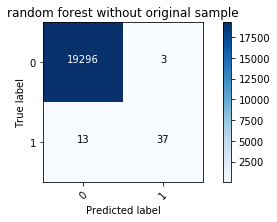

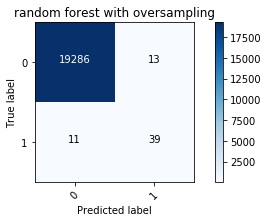

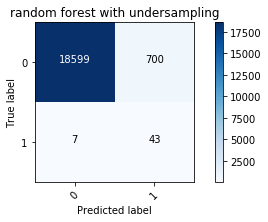

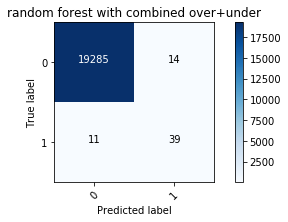

In [35]:
plt.figure(figsize=(6,3))
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, [0,1])
plt.title("random forest without original sample")

plt.figure(figsize=(6,3))
cm = confusion_matrix(Y_test, Y_over_pred)
plot_confusion_matrix(cm, [0,1])
plt.title("random forest with oversampling")

plt.figure(figsize=(6,3))
cm = confusion_matrix(Y_test, Y_under_pred)
plot_confusion_matrix(cm, [0,1])
plt.title("random forest with undersampling")

plt.figure(figsize=(6,3))
cm = confusion_matrix(Y_test, Y_comb_pred)
plot_confusion_matrix(cm, [0,1])
plt.title("random forest with combined over+under")



We now look at the most important features according to the model rf that we trained above. Based on these results we will eliminate some extra features.

In [36]:
#Looking at the most important features.
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',         
                                                                        ascending=True)
feature_importances

,importance
V9,0.008209
V2,0.009327
V5,0.009775
V1,0.010356
V18,0.012106
V16,0.019215
V11,0.019805
V12,0.023753
V7,0.029447
V4,0.065049


# Finetuning using randomizedsearch

In [37]:
#Let's start by reducing our space even further
X_train.drop(["V2","V1", "V11", "V18", "V5", "V9", "V7", "V4"], axis=1, inplace=True)
X_test.drop(["V2","V1", "V11", "V18", "V5", "V9", "V7", "V4"], axis=1, inplace=True)


/Users/hudsonps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/hudsonps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
#confirming that we dropped the right columns
X_train.head(3)

,V3,V10,V12,V14,V16,V17
207422,-0.904174,-0.338248,0.871934,0.226485,-0.793141,0.289525
2662,1.119794,-0.227621,0.430457,-0.111597,-1.579484,0.567716
113404,1.119531,0.254766,-0.116878,0.440542,-1.418081,-0.100273


Let's see if we can fine-tune a bit with gridsearch.

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
param_grid = {"max_depth": [2,3],
              "max_features": [2,3],
              "n_estimators": [80,100,150,200],
              "class_weight": [{0:1, 1:100}]
              }

cv_method = StratifiedKFold(n_splits=5, shuffle=True)

rf_grid = GridSearchCV(estimator = ensemble.RandomForestClassifier(),
                       param_grid = param_grid,
                       cv = cv_method,
                       scoring = 'recall')

In [41]:
rf_grid.fit(X_train, np.ravel(Y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3], 'max_features': [2, 3], 'n_estimators': [80, 100, 150, 200], 'class_weight': [{0: 1, 1: 100}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [42]:
rf_grid.best_params_

{'class_weight': {0: 1, 1: 100},
 'max_depth': 2,
 'max_features': 2,
 'n_estimators': 80}

In [43]:
Y_grid_pred = rf_grid.predict(X_test)

In [44]:
print(classification_report(Y_test, Y_grid_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19299
          1       0.78      0.80      0.79        50

avg / total       1.00      1.00      1.00     19349



Confusion matrix, without normalization
[[19288    11]
 [   10    40]]


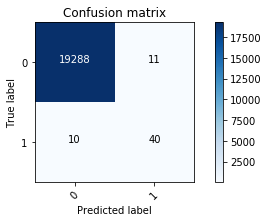

In [45]:
plt.figure(figsize=(6,3))
cm = confusion_matrix(Y_test, Y_grid_pred)
plot_confusion_matrix(cm, [0,1])

Let's finish this analysis by looking at what fraudulent transactions we are missing to see if there might be a pattern.

In [46]:

aux_df = pd.DataFrame({'col1': Y_test, 'col2': Y_grid_pred})

In [47]:
missing_index = np.asarray(aux_df[(aux_df.col1 == 1) & (aux_df.col2 == 0)].index)

In [48]:
rawdf.Amount[missing_index]

245556    357.95
142557    354.33
275992    634.30
52521     105.99
68067     519.90
58422     208.58
151196    571.48
96341      98.01
146790    829.41
39183     776.83
Name: Amount, dtype: float64

We can see that, of the 7 transactions we missed, 2 happen to be part of that tier of the 10 most expensive ones, which we expected to be difficult to classify. 

Nevertheless, the analysis above gave us a set of parameters to use:
{'class_weight': {0: 1, 1: 100},
 'max_depth': 2,
 'max_features': 2,
 'n_estimators': 100}
 
 The next step would be to look at transactions below the amount of 88, but we will leave that for another time.

In [61]:
Y_probs = rf_grid.predict_proba(X_test)

pos_probs = list(map(lambda l: l[1], Y_probs))

In [50]:
from sklearn.metrics import roc_curve, auc

In [66]:
fpr, tpr, thresholds = roc_curve(Y_test, pos_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

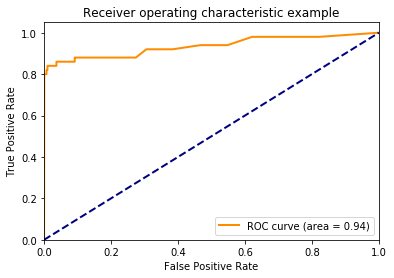

In [67]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()